### 1. Importing relevant packages and libraries

In [1]:
# Import libraries and packages

from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
# Read Data

df_data = pd.read_csv('/home/kinjal/Documents/Project 1/Customer_segment/customer_segmentation.csv', encoding = 'cp1252')

In [3]:
# Read data from csv

df_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# Initiate plotly

pyoff.init_notebook_mode()

#### 1.1 Feature Engineering

In [5]:
# Converting type of Invoice Date field

df_data['InvoiceDate'] = pd.to_datetime(df_data['InvoiceDate'])

In [6]:
# Creating Year-Month field for ease of reporting and visualization

df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month )

In [7]:
df_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  InvoiceYearMonth  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom            201012  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom            201012  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012

In [8]:
df_data.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  InvoiceYearMonth  
count  406829.000000     541909.000000  
mean    15287.690570     201099.713989  
min     12346.000000     201012.000000  
25%     13953.000000     201103.000000  
50%     15152.000000     201107.000000  
75%     16791.000000     201110.000000  
max     18287.000000     201112.000000  
std      1713.600303         25.788703

In [9]:
df_data['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


#### We will be focusing on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDs. The same analysis can be carried out for customers of other countries as well.

In [10]:
df_Uk = df_data.query("Country == 'United Kingdom'").reset_index(drop = True)

## Segmentation Techniques

#### We can do many different segmentations according to what you are trying to achieve. If we want to increase retention rate, we can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now, we are going to implement one of them to our business: RFA. RFA stands for Recency - Frequency - Avg Order Value (AOV). Theoretically we will have segments like below:

#### 1. Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

#### 2. Mid value: In the middle of everything. Often using our platform, fairly frequent and generates moderate revenue.

#### 3. High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

#### As the methodology, we need to calculate Recency, Frequency and Avg Order Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each.

## 2. Recency

#### To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having number of inactive days for each customer, we will apply K-means clustering to assign customers a recency score.

In [11]:
df_Uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  InvoiceYearMonth  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom            201012  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom            201012  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            201012

In [12]:
# create a generic user dataframe for CustomerID and new segmentation scores

df_user = pd.DataFrame(df_Uk['CustomerID'].unique())
df_user.columns = ['Customer ID']
df_user.head()

Customer ID
0      17850.0
1      13047.0
2      13748.0
3      15100.0
4      15291.0

#### Since, we are calculating recency, we need to know when last the person bought something. Let us calculate the last transaction of that person.

In [13]:
# Get max purchase date for each customer and create a dataframe

df_max_purchase = df_Uk.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['Customer ID','Max_Purchase_Date']
df_max_purchase.head()

Customer ID   Max_Purchase_Date
0      12346.0 2011-01-18 10:17:00
1      12747.0 2011-12-07 14:34:00
2      12748.0 2011-12-09 12:20:00
3      12749.0 2011-12-06 09:56:00
4      12820.0 2011-12-06 15:12:00

In [14]:
# Compare the last transaction of the dataset with the last transaction dates for each Customer IDs

df_max_purchase['Recency'] = (df_max_purchase['Max_Purchase_Date'].max()-df_max_purchase['Max_Purchase_Date']).dt.days
df_max_purchase.head()

Customer ID   Max_Purchase_Date  Recency
0      12346.0 2011-01-18 10:17:00      325
1      12747.0 2011-12-07 14:34:00        1
2      12748.0 2011-12-09 12:20:00        0
3      12749.0 2011-12-06 09:56:00        3
4      12820.0 2011-12-06 15:12:00        2

In [15]:
# Merge this dataframe to our new user dataframe

df_user = pd.merge(df_user, df_max_purchase[['Customer ID','Recency']], on = 'Customer ID')
df_user.head()

Customer ID  Recency
0      17850.0      301
1      13047.0       31
2      13748.0       95
3      15100.0      329
4      15291.0       25

### 2.1 Assigning a recency score

#### We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

In [16]:
from sklearn.cluster import KMeans

sse = {} # error

df_recency = df_user[['Recency']]

for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_recency)
    df_recency['clusters'] = kmeans.labels_  # cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ # sse corresponding to clusters

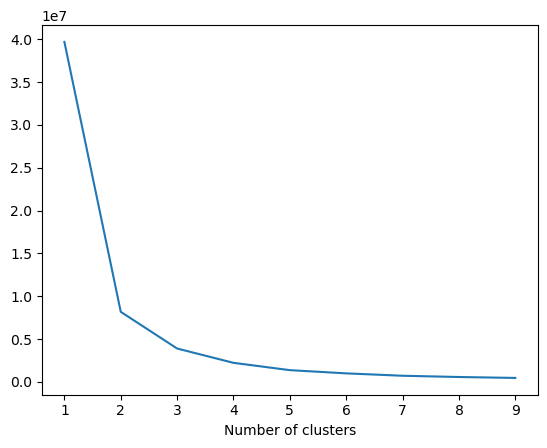

In [17]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

#### Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this dataset.

In [18]:
# Build 4 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters = 4)
df_user['Recency_Cluster'] = kmeans.fit_predict(df_user[['Recency']])

In [19]:
df_user.head()

Customer ID  Recency  Recency_Cluster
0      17850.0      301                2
1      13047.0       31                1
2      13748.0       95                0
3      15100.0      329                2
4      15291.0       25                1

In [20]:
round(df_user.groupby('Recency_Cluster')['Recency'].describe(), 2)

count    mean    std    min    25%    50%    75%    max
Recency_Cluster                                                          
0                 884.0   83.25  23.82   52.0   63.0   77.0  100.0  137.0
1                2055.0   19.14  14.72    0.0    7.0   17.0   30.0   51.0
2                 450.0  308.00  39.74  250.0  273.0  303.0  351.0  373.0
3                 561.0  190.84  31.87  138.0  164.0  189.0  217.0  249.0

### 2.2 Ordering Clusters

#### We have a cluster corresponding to each Customer ID. But each cluster is randomly assigned. Cluster 2 is not better than Cluster 1 for e.g. and so on. We want to give clusters according to most recent transactions.

#### We will first find the mean of recency value corresponding to each cluster. Then we will sort these values. Let's say cluster 3 has the most recent transactions mean value. From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. We will give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. Now we will drop the original cluster numbers and replace them with 0,1,2,3.

In [21]:
# We will define a function for ordering clusters

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name, ascending = ascending).reset_index(drop = True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('Recency_Cluster', 'Recency', df_user, False)

In [22]:
df_user.head()

Customer ID  Recency  Recency_Cluster
0      17850.0      301                0
1      15100.0      329                0
2      18074.0      373                0
3      16250.0      260                0
4      13747.0      373                0

In [23]:
round(df_user.groupby('Recency_Cluster')['Recency'].describe(), 2)

count    mean    std    min    25%    50%    75%    max
Recency_Cluster                                                          
0                 450.0  308.00  39.74  250.0  273.0  303.0  351.0  373.0
1                 561.0  190.84  31.87  138.0  164.0  189.0  217.0  249.0
2                 884.0   83.25  23.82   52.0   63.0   77.0  100.0  137.0
3                2055.0   19.14  14.72    0.0    7.0   17.0   30.0   51.0

#### So, cluster 1 is now cluster 0, cluster 2 is now cluster 1 and so on. Now, the clusters are ordered according to their inactivity. Cluster 0 is the most in-active while Cluster 3 is the most active.

## 3. Frequency

#### To create frequency clusters, first we need to find the total number of orders for each customer. 

In [24]:
# get order count for each customer and dataframe it

df_frequency = df_Uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['Customer ID', 'Frequency']

In [25]:
# Number of orders for each customer

df_frequency.head()

Customer ID  Frequency
0      12346.0          2
1      12747.0        103
2      12748.0       4642
3      12749.0        231
4      12820.0         59

In [26]:
# add this data to our user dataframe

df_user = pd.merge(df_user, df_frequency, on = 'Customer ID')
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency
0      17850.0      301                0        312
1      15100.0      329                0          6
2      18074.0      373                0         13
3      16250.0      260                0         24
4      13747.0      373                0          1

### 3.1 Frequency Clusters

#### We are going to apply K-means clustering to assign the number of Frequency Clusters. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. 

In [27]:
from sklearn.cluster import KMeans

sse = {} # error

df_frequency = df_user[['Frequency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_frequency)
    df_frequency['clusters'] = kmeans.labels_ # cluster names corresponding to frequency values
    sse[k] = kmeans.inertia_ # sse corresponding to clusters

/tmp/ipykernel_15035/4273874723.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15035/4273874723.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15035/4273874723.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

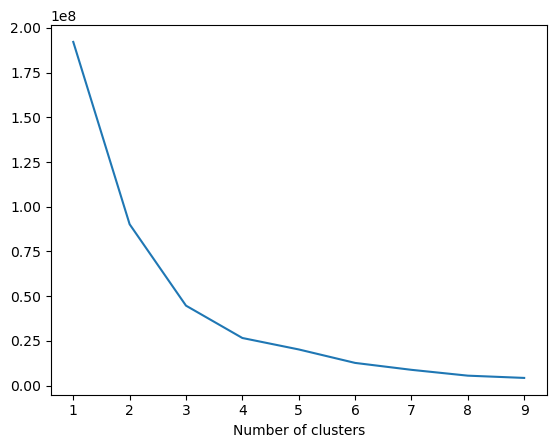

In [28]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

#### Here, the total number of optimal clusters is 3, but as per the data provided, we will be choosing the number of optimal clusters as 4.

In [29]:
# Build 4 clusters for frequency and add it to dataframe

kmeans = KMeans(n_clusters = 4)
df_user['Frequency_Cluster'] = kmeans.fit_predict(df_user[['Frequency']])

In [30]:
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster
0      17850.0      301                0        312                  2
1      15100.0      329                0          6                  0
2      18074.0      373                0         13                  0
3      16250.0      260                0         24                  0
4      13747.0      373                0          1                  0

### 3.2 Ordering Clusters

#### We have a cluster corresponding to each Customer ID. But each cluster is randomly assigned. Cluster 2 is not better than Cluster 1 for e.g. and so on. We want to give clusters according to most recent frequency of transactions.

In [31]:
#order the cluster numbers

df_user = order_cluster('Frequency_Cluster','Frequency', df_user, True)
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster
0      17850.0      301                0        312                  1
1      15808.0      305                0        210                  1
2      13047.0       31                3        196                  1
3      14688.0        7                3        359                  1
4      16029.0       38                3        274                  1

In [32]:
round(df_user.groupby('Frequency_Cluster')['Frequency'].describe(), 2)

count     mean      std     min     25%     50%     75%  \
Frequency_Cluster                                                             
0                  3496.0    49.53    44.95     1.0    15.0    33.0    73.0   
1                   429.0   331.22   133.86   191.0   228.0   287.0   399.0   
2                    22.0  1313.14   505.93   872.0   988.5  1140.0  1452.0   
3                     3.0  5917.67  1805.06  4642.0  4885.0  5128.0  6555.5   

                      max  
Frequency_Cluster          
0                   190.0  
1                   803.0  
2                  2782.0  
3                  7983.0

#### Cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

## 4. Revenue

#### Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [33]:
# Calculate revenue for each customer

df_Uk['Revenue'] = df_Uk['UnitPrice']*df_Uk['Quantity']
df_revenue = round(df_Uk.groupby('CustomerID').Revenue.mean().reset_index(), 2)
df_revenue.columns = ['Customer ID', 'Revenue']

In [34]:
df_revenue.head()

Customer ID  Revenue
0      12346.0     0.00
1      12747.0    40.74
2      12748.0     6.26
3      12749.0    16.75
4      12820.0    15.97

In [35]:
# Merge with the user dataframe

df_user = pd.merge(df_user, df_revenue, on = 'Customer ID')
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17850.0      301                0        312                  1   
1      15808.0      305                0        210                  1   
2      13047.0       31                3        196                  1   
3      14688.0        7                3        359                  1   
4      16029.0       38                3        274                  1   

   Revenue  
0    16.95  
1    17.74  
2    15.71  
3    14.23  
4   186.10

### 4.1 Revenue Clusters

#### We are going to apply K Means to assign the number of Revenue Clusters. But, we should tell the number of optimal clusters we need for K Means algorithm. To find out, we will apply the Elbow Method.

In [36]:
from sklearn.cluster import KMeans

sse = {} # error

df_revenue = df_user[['Revenue']]
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_frequency)
    df_frequency['clusters'] = kmeans.labels_ # cluster names corresponding to frequency values
    sse[k] = kmeans.inertia_ # sse corresponding to clusters

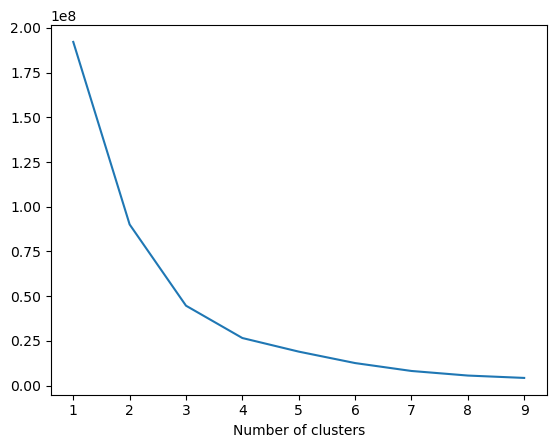

In [37]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

#### Here, the total number of optimal clusters is 3, but as per the data provided, we will be choosing the number of optimal clusters as 4.

In [38]:
# Build 4 clusters for frequency and add it to dataframe

kmeans = KMeans(n_clusters = 4)
df_user['Revenue_Cluster'] = kmeans.fit_predict(df_user[['Revenue']])

In [39]:
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17850.0      301                0        312                  1   
1      15808.0      305                0        210                  1   
2      13047.0       31                3        196                  1   
3      14688.0        7                3        359                  1   
4      16029.0       38                3        274                  1   

   Revenue  Revenue_Cluster  
0    16.95                2  
1    17.74                2  
2    15.71                2  
3    14.23                2  
4   186.10                2

### 4.2 Ordering clusters

#### We have a cluster corresponding to each Customer ID. But each cluster is randomly assigned. Cluster 2 is not better than Cluster 1 for e.g. and so on. We want to give clusters according to most Revenue generated.

In [40]:
#order the cluster numbers

df_user = order_cluster('Revenue_Cluster', 'Revenue',df_user,True)
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17850.0      301                0        312                  1   
1      15808.0      305                0        210                  1   
2      13047.0       31                3        196                  1   
3      14688.0        7                3        359                  1   
4      16029.0       38                3        274                  1   

   Revenue  Revenue_Cluster  
0    16.95                2  
1    17.74                2  
2    15.71                2  
3    14.23                2  
4   186.10                2

In [41]:
round(df_user.groupby('Revenue_Cluster')['Revenue'].describe(), 2)

count     mean      std      min      25%      50%      75%  \
Revenue_Cluster                                                                 
0                   1.0 -4287.63      NaN -4287.63 -4287.63 -4287.63 -4287.63   
1                   2.0 -1102.18   693.41 -1592.49 -1347.33 -1102.18  -857.02   
2                3941.0    27.09    54.21  -238.44    10.14    16.55    23.01   
3                   6.0  2248.35  1009.93  1377.08  1498.60  1860.15  2830.28   

                     max  
Revenue_Cluster           
0               -4287.63  
1                -611.86  
2                1001.20  
3                3861.00

#### Cluster 3 generates the highest revenue, and cluster 0 generates the lowest revenue

## 5. Overall score based on RFA Clustering

#### Now, we have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them.

In [42]:
# calculate overall score and use mean() to see details

df_user['Overall Score'] = df_user['Recency_Cluster'] + df_user['Frequency_Cluster'] + df_user['Revenue_Cluster']
round(df_user.groupby('Overall Score')[['Recency','Frequency','Revenue']].mean(), 2)

Recency  Frequency  Revenue
Overall Score                             
1               144.00       1.00 -4287.63
2               307.29      22.36    24.69
3               191.74      32.80    26.09
4                84.39      45.69    36.57
5                21.99      69.55    27.64
6                12.60     335.71    37.30
7                 5.95    1313.14    13.64
8                 1.33    5917.67     7.48

#### Customer with score 7 is our best customer, while customer with score 1 is our worst customer.

In [43]:
df_user['Segment'] = 'Low-value'
df_user.loc[df_user['Overall Score'] > 2, 'Segment'] = 'Mid-Value'
df_user.loc[df_user['Overall Score'] > 4, 'Segment'] = 'High-Value'

In [44]:
df_user

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0         17850.0      301                0        312                  1   
1         15808.0      305                0        210                  1   
2         13047.0       31                3        196                  1   
3         14688.0        7                3        359                  1   
4         16029.0       38                3        274                  1   
...           ...      ...              ...        ...                ...   
3945      15749.0      234                1         15                  0   
3946      13135.0      196                1          1                  0   
3947      17448.0      144                1          1                  0   
3948      15369.0      143                1          1                  0   
3949      13154.0      143                1          1                  0   

      Revenue  Revenue_Cluster  Overall Score     Segment  
0       16.95                2              3   Mid-Value  
1       17.74                2              3   Mid-Value  
2       15.71                2              6  High-Value  
3       14.23                2              6  High-Value  
4      186.10                2              6  High-Value  
...       ...              ...            ...         ...  
3945  1435.73                3              4   Mid-Value  
3946  3096.00                3              4   Mid-Value  
3947 -4287.63                0              1   Low-value  
3948 -1592.49                1              2   Low-value  
3949  -611.86                1              2   Low-value  

[3950 rows x 9 columns]

## 6. Customer Lifetime Value (CLV)

#### Since, our model is ready, let's calculate the LTV (Lifetime Value) for each customer over the past 6 months, which we are going to use for training our model.

#### Lifetime Value: Total Gross Revenue - Total Cost

#### There is no cost mentioned in the dataset, which means that the revenue directly becomes our LTV.

In [45]:
df_Uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

   InvoiceYearMonth  Revenue  
0            201012    15.30  
1            201012    20.34  
2            201012    22.00  
3            201012    20.34  
4            201012    20.34

In [46]:
df_Uk['InvoiceDate'].describe()

count                           495478
mean     2011-07-04 05:01:41.098131456
min                2010-12-01 08:26:00
25%                2011-03-27 12:06:00
50%                2011-07-19 11:47:00
75%                2011-10-20 10:41:00
max                2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

#### We see that customers are active from 1st December 2010. Let us consider customers from March onwards (so that they are not new customers). 

#### We shall divide them into two subgroups. One will be where the timeframe of analyzing is 3 months, and another where the timeframe of analyzing is 6 months.

In [47]:
df_3m = df_Uk[(df_Uk.InvoiceDate > datetime(2011,6,1)) & (df_Uk.InvoiceDate <= datetime(2011,3,1))].reset_index(drop = True) # 3 months time

df_6m = df_Uk[(df_Uk.InvoiceDate >= datetime(2011,6,1)) & (df_Uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop = True) # 6 months time


In [48]:
# calculate revenue for 6 months and create a new dataframe for it

df_6m['Revenue'] = df_6m['UnitPrice']*df_6m['Quantity']
df_user_6m = round(df_6m.groupby('CustomerID')['Revenue'].mean().reset_index(), 2)
df_user_6m.columns = ['Customer ID','m6_Revenue']

In [49]:
df_user_6m.head()

Customer ID  m6_Revenue
0      12747.0       40.64
1      12748.0        6.31
2      12749.0       16.83
3      12820.0       15.60
4      12822.0       19.55

In [50]:
# Plot LTV Histogram

plot_data = [go.Histogram(y = df_user_6m['m6_Revenue'])]

plot_layout = go.Layout(title = '6 month Revenue')

fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)

#### Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

#### Next, we will merge our 3 months and df_Uk and also 6 months and df_Uk dataframe to see correlations between LTV and the feature set we have.

In [51]:
df_Uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

   InvoiceYearMonth  Revenue  
0            201012    15.30  
1            201012    20.34  
2            201012    22.00  
3            201012    20.34  
4            201012    20.34

In [52]:
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17850.0      301                0        312                  1   
1      15808.0      305                0        210                  1   
2      13047.0       31                3        196                  1   
3      14688.0        7                3        359                  1   
4      16029.0       38                3        274                  1   

   Revenue  Revenue_Cluster  Overall Score     Segment  
0    16.95                2              3   Mid-Value  
1    17.74                2              3   Mid-Value  
2    15.71                2              6  High-Value  
3    14.23                2              6  High-Value  
4   186.10                2              6  High-Value

In [53]:
df_user = pd.merge(df_user, df_user_6m, on ='Customer ID', how ='left') #Only people who are in the timeline of df_user_6m

df_user = df_user.fillna(0) # fill the NaN values

df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17850.0      301                0        312                  1   
1      15808.0      305                0        210                  1   
2      13047.0       31                3        196                  1   
3      14688.0        7                3        359                  1   
4      16029.0       38                3        274                  1   

   Revenue  Revenue_Cluster  Overall Score     Segment  m6_Revenue  
0    16.95                2              3   Mid-Value        0.00  
1    17.74                2              3   Mid-Value        0.00  
2    15.71                2              6  High-Value       12.96  
3    14.23                2              6  High-Value       13.51  
4   186.10                2              6  High-Value      190.76

In [54]:
df_graph = df_user.query("m6_Revenue < 3200") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    
    go.Scatter(
        x = df_graph.query("Segment == 'Low-Value'")['Overall Score'],
        y = df_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
    
    go.Scatter(
        x = df_graph.query("Segment == 'Mid-Value'")['Overall Score'],
        y = df_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
    
    go.Scatter(
        x = df_graph.query("Segment == 'High-Value'")['Overall Score'],
        y = df_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    )
    
]

plot_layout = go.Layout(
                    yaxis = {'title' : '6m LTV'},
                    xaxis = {'title' : 'RFA Score'},
                    title = 'Customer Lifetime Value'    
)

fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)

#### We can visualise correlation between overall RFA score and revenue. Positive correlation is quite visible here. High RFA score means high CLV.

#### Before building the machine learning model, we need to identify what is the type of this machine learning problem. CLV itself is a regression problem. A machine learning model can predict the value of the CLV. But here, we want CLV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing CLV groups and build segments on top of it.

#### Considering business part of this analysis, we need to treat customers differently based on their predicted CLV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):

#### 1. Low CLV
#### 2. Mid CLV
#### 3. High CLV

#### Now, we are going to apply K Means clustering to decide segments and observe their characteristics

In [55]:
# remove outliers

df_user = df_user[df_user['m6_Revenue'] > df_user['m6_Revenue'].quantile(0.99)]

In [56]:
df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
97       17450.0        7                3        351                  1   
109      18102.0        0                3        433                  1   
196      16684.0        3                3        281                  1   
937      17396.0       38                3         27                  0   
943      17949.0        0                3         79                  0   

     Revenue  Revenue_Cluster  Overall Score     Segment  m6_Revenue  
97    534.14                2              6  High-Value      591.52  
109   592.24                2              6  High-Value      545.22  
196   234.49                2              6  High-Value      296.39  
937   271.51                2              5  High-Value      288.89  
943   667.73                2              5  High-Value      713.43

In [57]:
#creating 3 clusters

kmeans = KMeans(n_clusters=3)

df_user['CLV_Cluster'] = kmeans.fit_predict(df_user[['m6_Revenue']])

df_user.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
97       17450.0        7                3        351                  1   
109      18102.0        0                3        433                  1   
196      16684.0        3                3        281                  1   
937      17396.0       38                3         27                  0   
943      17949.0        0                3         79                  0   

     Revenue  Revenue_Cluster  Overall Score     Segment  m6_Revenue  \
97    534.14                2              6  High-Value      591.52   
109   592.24                2              6  High-Value      545.22   
196   234.49                2              6  High-Value      296.39   
937   271.51                2              5  High-Value      288.89   
943   667.73                2              5  High-Value      713.43   

     CLV_Cluster  
97             0  
109            0  
196            2  
937            2  
943            0

In [58]:
#order cluster number based on CLV

df_user = order_cluster('CLV_Cluster', 'm6_Revenue', df_user, True)

In [59]:
# observe details of the clusters

round(df_user.groupby('CLV_Cluster')['m6_Revenue'].describe(), 2)

count     mean     std      min      25%      50%      75%  \
CLV_Cluster                                                               
0             27.0   316.01   65.56   227.81   264.60   297.00   362.88   
1             10.0   603.96  112.43   487.60   511.37   568.37   691.17   
2              3.0  1615.05  416.93  1199.24  1406.02  1612.80  1822.95   

                max  
CLV_Cluster          
0             440.0  
1             800.0  
2            2033.1

#### We have finished LTV clustering and here are the characteristics of each clusters as shown above. 
#### Cluster 2 is the best with average 1615 CLV whereas 0 is the worst with 316 CLV.

## 7. Feature Engineering

#### There are a few more steps before training the machine learning model:

#### 1. Feature engineering.
#### 2. Convert categorical columns to numerical columns.
#### 3. We will check the correlation of features against our label, CLV clusters.
#### 4. We will split our feature set and label (CLV) as X and y. We use X to predict y.
#### 5. We will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.

In [60]:
#convert categorical columns to numerical

df_class = pd.get_dummies(df_user) #There is only one categorical variable segment
df_class.head()

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
0      17450.0        7                3        351                  1   
1      18102.0        0                3        433                  1   
2      17949.0        0                3         79                  0   
3      17857.0        2                3         56                  0   
4      16308.0       37                3          4                  0   

   Revenue  Revenue_Cluster  Overall Score  m6_Revenue  CLV_Cluster  \
0   534.14                2              6      591.52            1   
1   592.24                2              6      545.22            1   
2   667.73                2              5      713.43            1   
3   477.92                2              5      487.60            1   
4   640.00                2              5      800.00            1   

   Segment_High-Value  Segment_Mid-Value  
0                True              False  
1                True              False  
2                True              False  
3                True              False  
4                True              False

In [61]:
# calculate and show correlations

corr_matrix = df_class.corr()
corr_matrix['CLV_Cluster'].sort_values(ascending = False)

CLV_Cluster           1.000000
m6_Revenue            0.874369
Revenue               0.779737
Revenue_Cluster       0.587775
Segment_High-Value    0.400320
Overall Score         0.392981
Customer ID           0.383712
Recency_Cluster       0.230769
Frequency             0.148525
Frequency_Cluster     0.121590
Recency              -0.225367
Segment_Mid-Value    -0.400320
Name: CLV_Cluster, dtype: float64

In [62]:
#create X and y, X will be feature set and y is the label - CLV

X = df_class.drop(['CLV_Cluster','m6_Revenue'],axis=1)
y = df_class['CLV_Cluster']

# splitting train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 85, stratify = y)

## 8. XGBoost Model for Customer Lifetime Value Prediction

In [63]:
# XGB MultiClassification Model

model = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.1, n_jobs = -1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [64]:
y_pred = model.predict(X_test)

In [65]:
# Calculate accuracy of the model

print('Accuracy of XGB Classifier model for training set: {:.2f}'.format(model.score(X_train, y_train)))

print('Accuracy of XGB Classifier model for testing set: {:.2f}'.format(model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB Classifier model for training set: 1.00
Accuracy of XGB Classifier model for testing set: 0.83


#### Accuracy looks good on training and test set. Let's calculate the precision, recall and F Score too.

In [66]:
# Calculate MAE and RMSE

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.16666666666666666
RMSE: 0.408248290463863


In [67]:
# Validate the model using K-Fold Cross-validation

from sklearn.metrics import make_scorer

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

mae_scores = cross_val_score(model, X, y, cv = 20, scoring = mae_scorer)
rmse_scores = cross_val_score(model, X, y, cv = 20, scoring = rmse_scorer)

print("Mean CV MAE:", -mae_scores.mean())
print("Mean CV RMSE:", -rmse_scores.mean())


/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=20.

/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=20.



Mean CV MAE: 0.2
Mean CV RMSE: 0.26213203435596427


In [68]:
# Classification report

print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.60      1.00      0.75         3
           2       0.00      0.00      0.00         1

    accuracy                           0.83        12
   macro avg       0.53      0.62      0.56        12
weighted avg       0.82      0.83      0.81        12



## 9. Final Clusters for Customer Lifetime Value

### 1. Cluster 0: Good Precision, Recall, F1-Score, Support
### 2. Cluster 1: Needs better Precision, F1-Score and Support
### 3. Cluster 2: Bad Precision, Recall, F1-Score. Everything needs improvement.


#### If model tells us this customer belongs to cluster 0, 100 out of 100 will be correct (precision). And the model successfully identifies 100% of actual cluster 0 customers (recall).

#### We really need to improve the model for other clusters. For example, we barely detect 67% of Mid CLV customers.

### To improve the classification report, we will be using another model for prediction.

## 10. Random forest Model for Customer Lifetime Value Prediction

In [69]:
#create X and y, X will be feature set and y is the label - CLV

X_Rf = df_class.drop(['CLV_Cluster','m6_Revenue'],axis=1)
y_Rf = df_class['CLV_Cluster']

# splitting train and test sets

X_train_Rf, X_test_Rf, y_train_Rf, y_test_Rf = train_test_split(X_Rf, y_Rf, test_size = 0.4, random_state = 90, stratify = y_Rf)

In [70]:
# Random Forest Regression Model

from sklearn.ensemble import RandomForestClassifier

model_Rf = RandomForestClassifier(n_estimators=100, random_state = 90)
model_Rf.fit(X_train_Rf, y_train_Rf)

RandomForestClassifier(random_state=90)

In [71]:
y_pred_Rf = model.predict(X_test_Rf)

In [72]:
# Calculate accuracy of the model

print('Accuracy of Random Forest Classifier model for training set: {:.2f}'.format(model_Rf.score(X_train_Rf, y_train_Rf)))

print('Accuracy of Random Forest Classifier model for testing set: {:.2f}'.format(model_Rf.score(X_test_Rf[X_train_Rf.columns], y_test_Rf)))

Accuracy of Random Forest Classifier model for training set: 1.00
Accuracy of Random Forest Classifier model for testing set: 0.75


#### Accuracy looks good on training and test set. Let's calculate the precision, recall and F Score too.

In [73]:
# Calculate MAE and RMSE

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_Rf, y_pred_Rf)
rmse = np.sqrt(mean_squared_error(y_test_Rf, y_pred_Rf))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.0625
RMSE: 0.25


In [74]:
# Validate the model using K-Fold Cross-validation

from sklearn.metrics import make_scorer

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true_Rf, y_pred_Rf: np.sqrt(mean_squared_error(y_true_Rf, y_pred_Rf)), greater_is_better=False)

mae_scores = cross_val_score(model_Rf, X_Rf, y_Rf, cv = 20, scoring = mae_scorer)
rmse_scores = cross_val_score(model_Rf, X_Rf, y_Rf, cv = 20, scoring = rmse_scorer)

print("Mean CV MAE:", -mae_scores.mean())
print("Mean CV RMSE:", -rmse_scores.mean())


/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=20.

/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=20.



Mean CV MAE: 0.15
Mean CV RMSE: 0.21213203435596428


In [75]:
# Classification report

print(classification_report(y_test_Rf, y_pred_Rf, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.93      0.97      0.95        16
weighted avg       0.95      0.94      0.94        16



## 11. Segment customers based on Predicted CLV


### 11.1 Segment customers based on XGBoost Model

In [76]:
# predict the CLV

df_class['Predicted_CLV'] = model.predict(X)

In [77]:
# Segment customers using CLV segment

conditions = [
    df_class['Predicted_CLV'] < 1 ,
    (df_class['Predicted_CLV'] >= 1) & (df_class['Predicted_CLV'] < 2),
    df_class['Predicted_CLV'] >= 2
]
labels = ['Low-Value', 'Mid-Value', 'High-Value']
df_class['CLV_Segment'] = np.select(conditions, labels)

In [78]:
# View segmented customers

print(df_class[['Predicted_CLV', 'CLV_Segment']])

    Predicted_CLV CLV_Segment
0               1   Mid-Value
1               1   Mid-Value
2               1   Mid-Value
3               1   Mid-Value
4               1   Mid-Value
5               1   Mid-Value
6               1   Mid-Value
7               1   Mid-Value
8               1   Mid-Value
9               1   Mid-Value
10              0   Low-Value
11              0   Low-Value
12              0   Low-Value
13              0   Low-Value
14              1   Mid-Value
15              0   Low-Value
16              0   Low-Value
17              0   Low-Value
18              0   Low-Value
19              0   Low-Value
20              0   Low-Value
21              0   Low-Value
22              0   Low-Value
23              0   Low-Value
24              0   Low-Value
25              0   Low-Value
26              0   Low-Value
27              0   Low-Value
28              0   Low-Value
29              0   Low-Value
30              0   Low-Value
31              0   Low-Value
32        

### 11.1 Segment customers based on Random Forest Model

In [79]:
# predict the CLV

df_class['Predicted_CLV'] = model_Rf.predict(X_Rf)

In [80]:
# Segment customers using CLV segment

conditions = [
    df_class['Predicted_CLV'] < 1,
    (df_class['Predicted_CLV'] >= 1) & (df_class['Predicted_CLV'] < 2),
    df_class['Predicted_CLV'] >= 2
]
labels = ['Low-Value', 'Mid-Value', 'High-Value']
df_class['CLV_Segment'] = np.select(conditions, labels)

In [81]:
# View segmented customers

print(df_class[['Predicted_CLV', 'CLV_Segment']])

    Predicted_CLV CLV_Segment
0               1   Mid-Value
1               1   Mid-Value
2               1   Mid-Value
3               1   Mid-Value
4               1   Mid-Value
5               1   Mid-Value
6               1   Mid-Value
7               1   Mid-Value
8               1   Mid-Value
9               0   Low-Value
10              0   Low-Value
11              0   Low-Value
12              0   Low-Value
13              0   Low-Value
14              1   Mid-Value
15              0   Low-Value
16              0   Low-Value
17              0   Low-Value
18              0   Low-Value
19              0   Low-Value
20              0   Low-Value
21              0   Low-Value
22              0   Low-Value
23              0   Low-Value
24              0   Low-Value
25              0   Low-Value
26              0   Low-Value
27              0   Low-Value
28              0   Low-Value
29              0   Low-Value
30              0   Low-Value
31              0   Low-Value
32        

## 12. Visualize CLV Segment Distribution

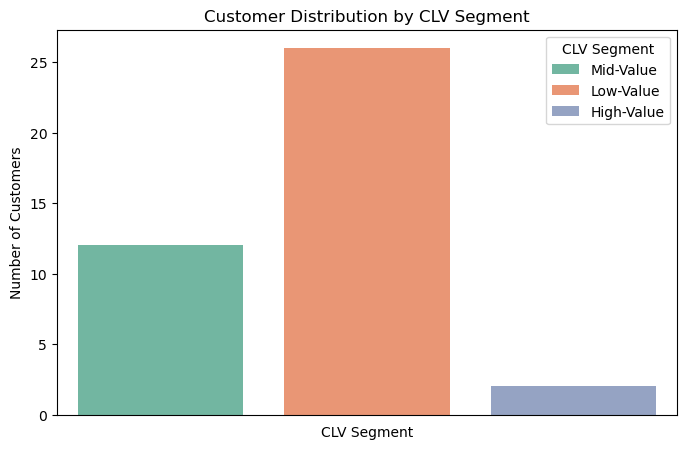

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for CLV Segments
plt.figure(figsize = (8, 5))
sns.countplot(data = df_class, x='CLV_Segment', hue = 'CLV_Segment', palette = 'Set2', legend = True)
plt.title('Customer Distribution by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Number of Customers')
plt.legend(title='CLV Segment')
plt.xticks([])
plt.show()

## 13. Analyze Segment Behaviors (e.g., Recency, Frequency, Revenue)

### 13.1 Compare Recency by CLV Segment

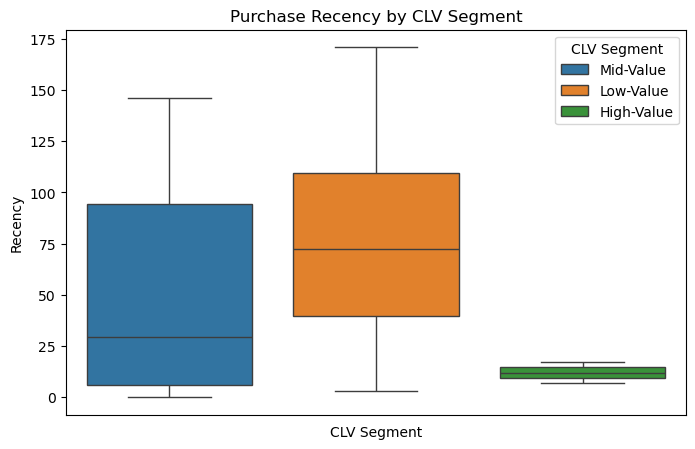

In [83]:
plt.figure(figsize=(8, 5))
sns.boxplot(data = df_class, x = 'CLV_Segment', y = 'Recency', hue = 'CLV_Segment', palette = 'tab10', legend = True)
plt.title('Purchase Recency by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Recency')
plt.legend(title='CLV Segment')
plt.xticks([])
plt.show()

### 13.2 Compare Frequency by CLV Segment

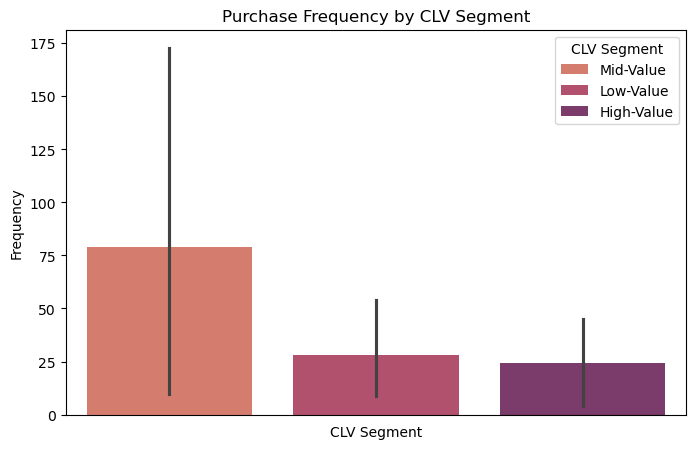

In [84]:
plt.figure(figsize=(8, 5))
sns.barplot(data = df_class, x = 'CLV_Segment', y = 'Frequency', hue = 'CLV_Segment', palette = 'flare', legend = True)
plt.title('Purchase Frequency by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Frequency')
plt.legend(title='CLV Segment')
plt.xticks([])
plt.show()

### 13.2 Compare Revenue by CLV Segment

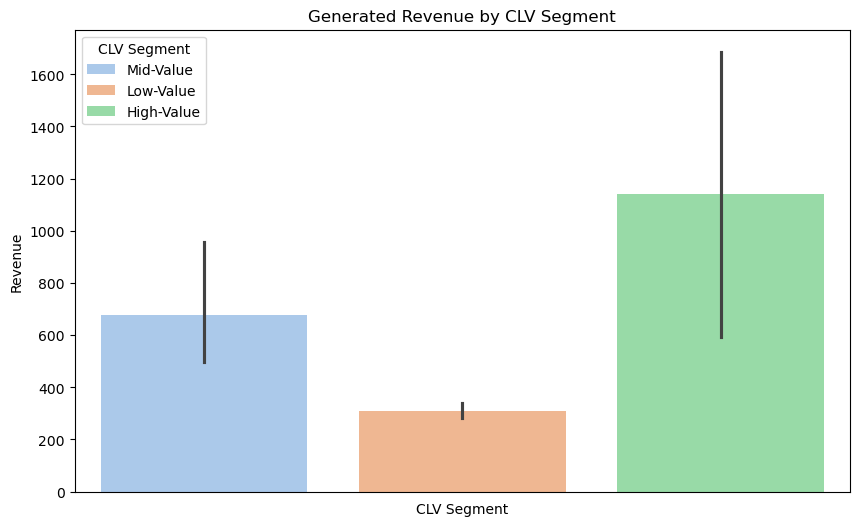

In [85]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_class, x = 'CLV_Segment', y = 'Revenue', hue='CLV_Segment', palette='pastel', legend = True)
plt.title('Generated Revenue by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Revenue')
plt.legend(title='CLV Segment')
plt.xticks([])
plt.show()

## 14. Marketing Strategy by Segment

In [94]:
high_value_customers = df_class[df_class['CLV_Segment'] == 'High-Value']

high_value_customers.to_csv('high_value_customers.csv', index=False)

pd.DataFrame(high_value_customers)

Customer ID  Recency  Recency_Cluster  Frequency  Frequency_Cluster  \
37      16333.0        7                3         45                  0   
38      16532.0       17                3          4                  0   

    Revenue  Revenue_Cluster  Overall Score  m6_Revenue  CLV_Cluster  \
37   591.71                2              5     1199.24            2   
38  1687.20                3              6     1612.80            2   

    Segment_High-Value  Segment_Mid-Value  Predicted_CLV CLV_Segment  
37                True              False              2  High-Value  
38                True              False              2  High-Value